## Separacion los datos en Train, Validacion y Test

In [24]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [25]:
df = pd.read_csv('../data/processed/Airbnb_Data_encoded.csv')
print("Columnas del dataset:")
print(df.columns.tolist())

Columnas del dataset:
['log_price', 'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room', 'accommodates', 'bathrooms', 'bed_type_Real Bed', 'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Couch', 'bed_type_Airbed', 'cancellation_policy_strict', 'cancellation_policy_moderate', 'cancellation_policy_flexible', 'cancellation_policy_super_strict_30', 'cancellation_policy_super_strict_60', 'cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds', 'total_amenities', 'amenities_per_guest', 'bathrooms_per_bedroom', 'beds_per_bedroom', 'accommodates_per_bedroom', 'property_type_freq', 'zipcode_freq']


Definir el target y los features:

In [26]:
target = 'log_price'

features = [col for col in df.columns if col != target]

X = df[features]
y = df[target]

Dividir el dataset en entrenamiento y prueba:

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

# --- 3. Verificar solapamiento de índices entre train y test ---
overlap = set(X_train.index).intersection(set(X_test.index))
print("Índices superpuestos entre train y test:", overlap)

Tamaño del conjunto de entrenamiento: (59288, 30)
Tamaño del conjunto de prueba: (14823, 30)
Índices superpuestos entre train y test: set()


Escalar los datos:

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Funcion de evaluacion:

In [29]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Crear un diccionario para guardar las métricas
results = {}

## Entrenamiento de los modelos:

Regresión Lineal (Ecuación Normal):

In [30]:
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)
y_pred_lr = model_lr.predict(X_test_scaled)
results['LinearRegression'] = evaluate_model(y_test, y_pred_lr)

Regresión Lineal con SVD:

In [31]:
def linear_regression_svd(X, y):
    # Agregar columna de unos para el intercepto
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    U, S, VT = np.linalg.svd(X_b, full_matrices=False)
    S_inv = np.diag(1 / S)
    theta = VT.T.dot(S_inv).dot(U.T).dot(y)
    return theta

theta_svd = linear_regression_svd(X_train_scaled, y_train.values)

# Predecir en el conjunto de prueba
X_test_b = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]
y_pred_svd = X_test_b.dot(theta_svd)
results['LinearRegression_SVD'] = evaluate_model(y_test, y_pred_svd)

Regresion Polinomial:

In [32]:
model_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('lr', LinearRegression())
])
model_poly.fit(X_train_scaled, y_train)
y_pred_poly = model_poly.predict(X_test_scaled)
results['PolynomialRegression_deg2'] = evaluate_model(y_test, y_pred_poly)

Regresión Lineal con Batch Gradient Descent:

In [33]:
# Usamos SGDRegressor configurado para trabajar en modo batch (usando todo el dataset en cada actualización)
model_batch = SGDRegressor(max_iter=4000, tol=1e-3, random_state=42, learning_rate='constant', eta0=0.01)
model_batch.fit(X_train_scaled, y_train)
y_pred_batch = model_batch.predict(X_test_scaled)
results['BatchGradientDescent'] = evaluate_model(y_test, y_pred_batch)

Regresión Lineal con Stochastic Gradient Descent:

In [34]:
model_sgd = SGDRegressor(max_iter=4000, tol=1e-3, random_state=42, learning_rate='optimal')
model_sgd.fit(X_train_scaled, y_train)
y_pred_sgd = model_sgd.predict(X_test_scaled)
results['StochasticGD'] = evaluate_model(y_test, y_pred_sgd)

Lasso Regression:

In [35]:
model_lasso = Lasso(alpha=0.1, max_iter=10000, random_state=42)
model_lasso.fit(X_train_scaled, y_train)
y_pred_lasso = model_lasso.predict(X_test_scaled)
results['Lasso'] = evaluate_model(y_test, y_pred_lasso)

Ridge Regression:

In [36]:
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train_scaled, y_train)
y_pred_ridge = model_ridge.predict(X_test_scaled)
results['Ridge'] = evaluate_model(y_test, y_pred_ridge)

## Resultados:

In [37]:
results_df = pd.DataFrame(results, index=['MSE', 'RMSE', 'MAE', 'R²']).T
print("Comparación de Modelos:")
display(results_df)

Comparación de Modelos:


,MSE,RMSE,MAE,R²
LinearRegression,1.861904e-01,4.314979e-01,3.404285e-01,5.440547e-01
LinearRegression_SVD,1.861905e-01,4.314980e-01,3.403820e-01,5.440544e-01
PolynomialRegression_deg2,1.759241e-01,4.194330e-01,3.285096e-01,5.691951e-01
BatchGradientDescent,6.579742e+22,2.565101e+11,2.179101e+10,-1.611255e+23
StochasticGD,1.871529e-01,4.326117e-01,3.404868e-01,5.416977e-01
Lasso,2.177898e-01,4.666795e-01,3.748119e-01,4.666738e-01
Ridge,1.861904e-01,4.314979e-01,3.404286e-01,5.440547e-01


## Visualizaciones:

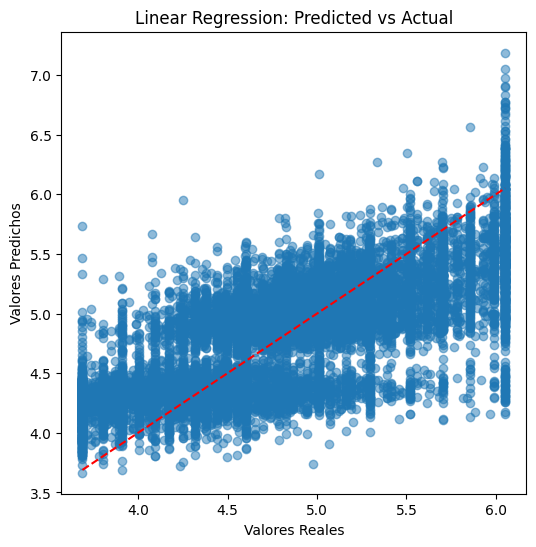

In [38]:
def plot_predicted_vs_actual(y_true, y_pred, model_name="Modelo"):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.title(f"{model_name}: Predicted vs Actual")
    plt.xlabel("Valores Reales")
    plt.ylabel("Valores Predichos")
    plt.show()
    
plot_predicted_vs_actual(y_test, y_pred_lr, model_name="Linear Regression")

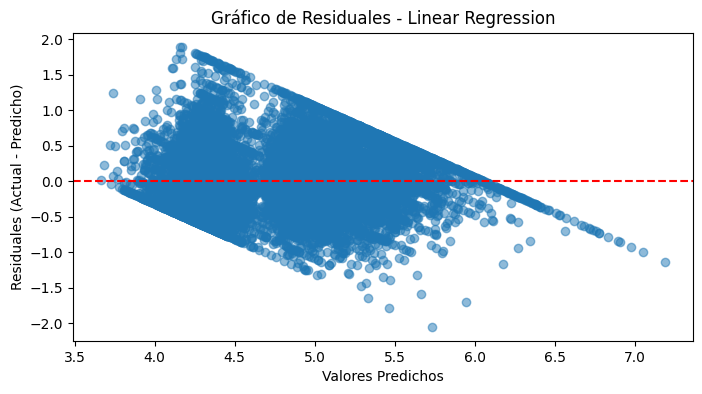

In [39]:
def plot_residuals(y_true, y_pred, model_name="Modelo"):
    residuals = y_true - y_pred
    plt.figure(figsize=(8,4))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f"Gráfico de Residuales - {model_name}")
    plt.xlabel("Valores Predichos")
    plt.ylabel("Residuales (Actual - Predicho)")
    plt.show()

plot_residuals(y_test, y_pred_lr, "Linear Regression")

Pruebas para ver si hay overfitting:

In [40]:
def print_train_test_errors(model, X_train, y_train, X_test, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
    print(f"{model_name} - Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

print_train_test_errors(model_lr, X_train_scaled, y_train, X_test_scaled, y_test, "LinearRegression")
print_train_test_errors(model_sgd, X_train_scaled, y_train, X_test_scaled, y_test, "SGDRegressor")
print_train_test_errors(model_ridge, X_train_scaled, y_train, X_test_scaled, y_test, "Ridge")

# --- 7. Validación cruzada ---
cv_scores_lr = cross_val_score(model_lr, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)
cv_rmse_lr = np.mean([sqrt(-score) for score in cv_scores_lr])
print("LinearRegression - CV RMSE:", cv_rmse_lr)

cv_scores_sgd = cross_val_score(model_sgd, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)
cv_rmse_sgd = np.mean([sqrt(-score) for score in cv_scores_sgd])
print("SGDRegressor - CV RMSE:", cv_rmse_sgd)

cv_scores_ridge = cross_val_score(model_ridge, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)
cv_rmse_ridge = np.mean([sqrt(-score) for score in cv_scores_ridge])
print("Ridge - CV RMSE:", cv_rmse_ridge)


LinearRegression - Train RMSE: 0.4324, Test RMSE: 0.4315
SGDRegressor - Train RMSE: 0.4338, Test RMSE: 0.4326
Ridge - Train RMSE: 0.4324, Test RMSE: 0.4315
LinearRegression - CV RMSE: 0.432668768801636
SGDRegressor - CV RMSE: 0.43460370915760826
Ridge - CV RMSE: 0.43266875145868866


In [41]:
score_lr = model_lr.score(X_test_scaled, y_test)
score_sgd = model_sgd.score(X_test_scaled, y_test)
score_ridge = model_ridge.score(X_test_scaled, y_test)

print("LinearRegression R² (test):", score_lr)
print("SGDRegressor R² (test):", score_sgd)
print("Ridge R² (test):", score_ridge)

LinearRegression R² (test): 0.5440546654906496
SGDRegressor R² (test): 0.541697714508387
Ridge R² (test): 0.5440547094112639
